In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import normal as randn, multivariate_normal as randmn
import pandas as pd
from collections.abc import Iterable
from algorithms.score_based import *
from algorithms.fast_contrastive_change_point import compute_test_stat_ftal
from algorithms.kliep import compute_test_stat_kliep
from algorithms.m_statistic import compute_test_stat_mmd
from algorithms.cusum import compute_cusum

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def reference_score(x):
    if isinstance(x, (int, float)):
        return np.array([-x]).reshape(-1, 1)
    return -x.reshape(-1, 1)

In [6]:
def compute_delays_false_alarms(runs, S_list, threshold, tau):
    delays = []
    false_alarms = 0
    not_detected = 0

    for i in range(runs):

        S = S_list[i]
        res = np.ma.flatnotmasked_edges(np.ma.masked_array(S, S <= threshold))
        if isinstance(res, Iterable):
            imin, _ = res
            if imin - tau <= 0:
                print(imin, i)
                false_alarms += 1
            else:
                delays.append(imin - tau)
        else:
            not_detected +=1

    if not_detected == runs or false_alarms == runs:
        return false_alarms, 0, 0, not_detected

    delays = np.array(delays)
    mean_delay = np.round(delays.mean(), 1)
    std_delay = np.round(delays.std(), 1)

    return false_alarms, mean_delay, std_delay, not_detected

## Univariate mean shift

### KLIEP, M-statistic, CUSUM

In [17]:
# kliep, m-stat, cusum

np.random.seed(1)
n = 300
tau = 150
sigma = 0.2
mu = 2 * sigma
runs = 10


S_kliep_list = []
S_mmd_list = []
S_cusum_list = []

for item in range(10):
    X = sigma * randn(size=n)
    X[tau:] += mu

    S_kliep, _ = compute_test_stat_kliep(X, window_size=20, sigma=0.33)
    S_mmd, _ = compute_test_stat_mmd(X, window_size=20, sigma=1)
    S_cusum, _ = compute_cusum(X)
    
    S_kliep_list.append(S_kliep)
    S_mmd_list.append(S_mmd)
    S_cusum_list.append(S_cusum)

threshold_kliep = 7.6216
fa_kliep, DD_kliep, std_DD_kliep, not_detected = compute_delays_false_alarms(runs, S_kliep_list, threshold_kliep, tau)
print('KLIEP. False alarms:', fa_kliep)
print('KLIEP', DD_kliep, '±', std_DD_kliep, 'nd:', not_detected)

threshold_mmd = 9.5924
fa_mmd, DD_mmd, std_DD_mmd, not_detected = compute_delays_false_alarms(runs, S_mmd_list, threshold_mmd, tau)
print('M-statistic. False alarms:', fa_mmd)
print('M-statistic', DD_mmd, '±', std_DD_mmd, 'nd:', not_detected)

threshold_cusum = 0.908
fa_cusum, DD_cusum, std_DD_cusum, not_detected = compute_delays_false_alarms(runs, S_cusum_list, threshold_cusum, tau)
print('CUSUM. False alarms:', fa_cusum)
print('CUSUM', DD_cusum, '±', std_DD_cusum, 'nd:', not_detected)



KLIEP. False alarms: 0
KLIEP 9.3 ± 3.6 nd: 0
M-statistic. False alarms: 0
M-statistic 10.5 ± 3.8 nd: 0
CUSUM. False alarms: 0
CUSUM 5.4 ± 2.4 nd: 0


### FALCON

In [8]:


def train_params_falcon(p_list, beta_list):
    n = 300
    tau = 150
    runs = 10
    sigma = 0.2
    dim = 1

    p = 2

    np.random.seed(1)
    for p in p_list:
        for b in beta_list:
            # threshold 
            S_0 = np.empty((20, tau))
            for item in range(20):
                X = sigma * randn(size=tau).reshape((tau, dim, 1))                
                S, _ = compute_test_stat_ftal(X, p, beta=b, design='hermite')
                S_0[item] = S
            threshold = np.max(S_0)
            print('threshold = ', threshold)


            S_list = np.empty((runs, n))
            for item in range(runs):
                X = sigma * randn(size=n).reshape((n, dim, 1))      
                X[tau:] += 2*sigma          
                S, _ = compute_test_stat_ftal(X, p, beta=b, design='hermite')
                S_list[item] = S

            false_alarms, mean_delay, std_delay, not_detected = compute_delays_false_alarms(runs, S_list, threshold, tau)
            print(f'power = {np.round(p, 4)}, beta = {np.round(b, 4)}', ' False alarms:', false_alarms, 'DD : ', mean_delay, '±', std_delay, 'not detected: ', not_detected)


In [112]:
train_params_falcon([2], np.linspace(0.001, 0.1, 10))

threshold =  0.7578262988665923
86 0
power = 2, beta = 0.001  False alarms: 1 DD :  6.8 ± 3.0 not detected:  0
threshold =  3.3761725864138006
power = 2, beta = 0.012  False alarms: 0 DD :  6.4 ± 1.8 not detected:  0
threshold =  3.0363173495991074
138 3
power = 2, beta = 0.023  False alarms: 1 DD :  8.1 ± 3.0 not detected:  0
threshold =  3.3071780674438105
power = 2, beta = 0.034  False alarms: 0 DD :  10.5 ± 2.8 not detected:  0
threshold =  2.9128866967056224
power = 2, beta = 0.045  False alarms: 0 DD :  9.0 ± 2.0 not detected:  0
threshold =  2.4409429220648913
91 0
power = 2, beta = 0.056  False alarms: 1 DD :  8.4 ± 2.6 not detected:  0
threshold =  3.1905176535342417
power = 2, beta = 0.067  False alarms: 0 DD :  10.0 ± 3.6 not detected:  0
threshold =  2.7594323571309336
power = 2, beta = 0.078  False alarms: 0 DD :  9.4 ± 2.8 not detected:  0
threshold =  3.1559584714621494
power = 2, beta = 0.089  False alarms: 0 DD :  10.5 ± 4.3 not detected:  0
threshold =  2.264775166768

In [10]:
n = 300
tau = 150
runs = 5
sigma = 0.2
dim = 1

p = 3

np.random.seed(1)

# threshold 
S_0 = np.empty((9, tau))
for item in range(9):
    X = sigma * randn(size=tau).reshape((tau, dim, 1))                
    S, _ = compute_test_stat_ftal(X, p, beta=0.1, design='hermite')
    S_0[item] = S
threshold = np.max(S_0) 
print('threshold = ', threshold)


S_list = np.empty((runs, n))
for item in range(runs):
    X = sigma * randn(size=n).reshape((n, dim, 1))      
    X[tau:] += 2*sigma          
    S, _ = compute_test_stat_ftal(X, p, beta=0.1, design='hermite')
    S_list[item] = S

false_alarms, mean_delay, std_delay, not_detected = compute_delays_false_alarms(runs, S_list, threshold, tau)
print(f'False alarms:', false_alarms, 'DD : ', mean_delay, '±', std_delay, 'not detected: ', not_detected)


threshold =  2.0504960822221356
False alarms: 0 DD :  8.0 ± 2.4 not detected:  0


In [65]:
n = 300
tau = 150
runs = 5
sigma = 0.2
dim = 1

p = 2

np.random.seed(1)

# threshold 
S_0 = np.empty((9, tau))
for item in range(9):
    X = sigma * randn(size=tau).reshape((tau, dim, 1))                
    S, _ = compute_test_stat_ftal(X, p, beta=0.01, design='hermite')
    S_0[item] = S
threshold = np.max(S_0) + 0.8
print('threshold = ', threshold)


S_list = np.empty((runs, n))
for item in range(runs):
    X = sigma * randn(size=n).reshape((n, dim, 1))      
    X[tau:] += 2*sigma          
    S, _ = compute_test_stat_ftal(X, p, beta=0.01, design='hermite')
    S_list[item] = S

false_alarms, mean_delay, std_delay, not_detected = compute_delays_false_alarms(runs, S_list, threshold, tau)
print(f'False alarms:', false_alarms, 'DD : ', mean_delay, '±', std_delay, 'not detected: ', not_detected)


threshold =  2.871580818443185
False alarms: 0 DD :  4.8 ± 2.4 not detected:  0


##  Univariate variance shift

#### FALCON, KLIEP, M-statistic

Polynomials. False alarms: 0
polynomial basis 11.4 ± 5.1  not detected:  0


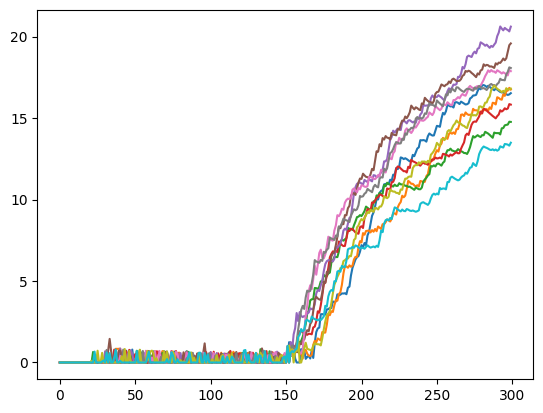

In [66]:
# fast contrastive cpd
np.random.seed(1)

runs = 10
n = 300
tau = 150
sigma1 = 0.1
sigma2 = 0.3

p = 3
S_hermite_list = []


for item in range(runs):
    X = randn(size=n)
    X[:tau] *= sigma1
    X[tau:] *= sigma2
    S_hermite, _ = compute_test_stat_ftal(X, p, beta=0.001, design='hermite')
    S_hermite_list.append(S_hermite)

threshold = 1.4474
fa_herm, DD_herm, std_DD_herm, not_detected = compute_delays_false_alarms(runs, S_hermite_list, threshold, tau)
        
print('Polynomials. False alarms:', fa_herm)
print('polynomial basis', DD_herm, '±', std_DD_herm, ' not detected: ', not_detected)

plt.plot(np.array(S_hermite_list).T)
plt.show()

In [67]:
# kliep, m-stat
runs=10

np.random.seed(1)
n = 300
tau = 150
sigma1 = 0.1
sigma2 = 0.3


S_kliep_list = []
S_mmd_list = []

for item in range(runs):
    X = randn(size=n)
    X[:tau] *= sigma1
    X[tau:] *= sigma2

    S_kliep, _ = compute_test_stat_kliep(X, window_size=20, sigma=0.33)
    S_mmd, _ = compute_test_stat_mmd(X, window_size=20, sigma=0.7)
    
    S_kliep_list.append(S_kliep)
    S_mmd_list.append(S_mmd)



In [68]:

fa_kliep, DD_kliep, std_DD_kliep, not_detected = compute_delays_false_alarms(runs, S_kliep_list, 4.153 , tau)
print('KLIEP. False alarms:', fa_kliep)
print('KLIEP', DD_kliep, '±', std_DD_kliep, 'nd: ', not_detected)


fa_mmd, DD_mmd, std_DD_mmd, not_detected = compute_delays_false_alarms(runs, S_mmd_list, 5.5565, tau)
print('M-statistic. False alarms:', fa_mmd)
print('M-statistic', DD_mmd, '±', std_DD_mmd, 'nd: ', not_detected)

# threshold_cusum = threshold_1d_cusum_03
# fa_cusum, DD_cusum, std_DD_cusum, not_detected = compute_delays_false_alarms(runs, S_cusum_list, 0.4469, tau)
# print('CUSUM. False alarms:', fa_cusum)
# print('CUSUM', DD_cusum, '±', std_DD_cusum, 'nd: ', not_detected)

KLIEP. False alarms: 0
KLIEP 21.8 ± 20.2 nd:  0
M-statistic. False alarms: 0
M-statistic 20.2 ± 14.4 nd:  0


## Multivariate mean shift

### FALCON

0.0


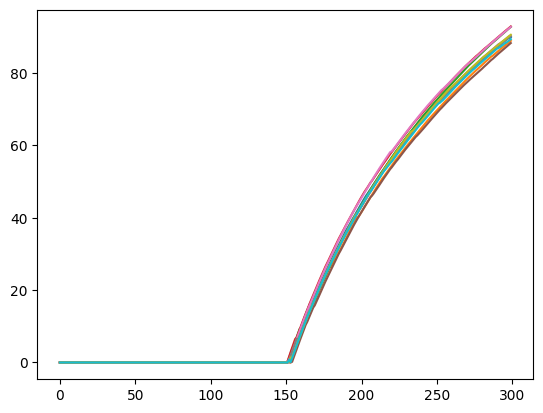

threshold:  0.0
FALCON. False alarms: 0
DD:  1.4 ± 0.9


In [10]:
# fast contrastive cpd
np.random.seed(1)

runs = 10
n = 300
tau = 150
dim=3
sigma = np.array([0.1, 0.2, 0.3])
mean = np.zeros(dim)
cov = np.eye(dim)



S_ftal_0 = np.empty((runs-1, tau))

#threshold
for item in range(runs-1):
    X = randmn(mean, cov, size=tau) * sigma[None, :]
    S_ftal, _ = compute_test_stat_ftal(X, p=1, beta=0.0001, design='multivariate')
    S_ftal_0[item] = S_ftal

threshold = np.max(S_ftal_0)
print(threshold)

# detect
S_ftal_list = np.empty((runs, n))
for item in range(runs):
    X = randmn(mean, cov, size=n) * sigma[None, :]
    X[tau:] += 3*sigma[None, :]
    
    S_ftal, _ = compute_test_stat_ftal(X, p=1, beta=0.0001, design='multivariate')
    S_ftal_list[item] = S_ftal


plt.plot(S_ftal_list.T)
plt.show()


fa_ftal, DD_ftal, std_DD_ftal, nd = compute_delays_false_alarms(runs, S_ftal_list, threshold, tau)
        
print('threshold: ', threshold)
print('FALCON. False alarms:', fa_ftal)
print('DD: ', DD_ftal, '±', std_DD_ftal)


### KLIEP

In [18]:
# kliep
def train_params_kliep(b_list, thrs_add=0):
    for b in b_list:
        np.random.seed(1)

        runs = 10
        n = 300
        tau = 150
        dim=3
        sigma = np.array([0.1, 0.2, 0.3])
        mean = np.zeros(dim)
        cov = np.eye(dim)

        S_kliep_0 = np.empty((runs-1, tau))

        #threshold
        for item in range(runs-1):
            X = randmn(mean, cov, size=tau) * sigma[None, :]
            S_kliep, _ = compute_test_stat_kliep(X,window_size=20, sigma=b)
            S_kliep_0[item] = S_kliep

        threshold = np.max(S_kliep_0) + thrs_add
        print(threshold)

        # detect
        S_kliep_list = np.empty((runs, n))
        for item in range(runs):
            X = randmn(mean, cov, size=n) * sigma[None, :]
            X[tau:] += 3*sigma[None, :]
            
            S_kliep, _ = compute_test_stat_kliep(X,window_size=20, sigma=b)
            S_kliep_list[item] = S_kliep


        fa_kliep, DD_kliep, std_DD_kliep, nd = compute_delays_false_alarms(runs, S_kliep_list, threshold, tau)
                
        print('KLIEP. Threshold: ', threshold, 'False alarms:', fa_kliep, 'DD: ', DD_kliep, '±', std_DD_kliep, 'nd: ', nd)
    return S_kliep_list

In [21]:
S = train_params_kliep([0.5, 1, 1.5, 2, 2.5, 3], thrs_add=0.5)

10.84784422461972


/Users/annal/.pyenv/versions/3.10.10/lib/python3.10/site-packages/cvxpy/atoms/elementwise/log.py:35: RuntimeWarning: invalid value encountered in log
  return np.log(values[0])


139 1
61 4
KLIEP. Threshold:  10.84784422461972 False alarms: 2 DD:  4.2 ± 1.1 nd:  0
4.0575831798711395
139 1
61 4
KLIEP. Threshold:  4.0575831798711395 False alarms: 2 DD:  4.9 ± 1.9 nd:  0
2.2445012435334832
139 1
KLIEP. Threshold:  2.2445012435334832 False alarms: 1 DD:  4.9 ± 2.2 nd:  0
1.4863627309905454
KLIEP. Threshold:  1.4863627309905454 False alarms: 0 DD:  6.3 ± 2.7 nd:  0
1.154473224691578
KLIEP. Threshold:  1.154473224691578 False alarms: 0 DD:  6.9 ± 2.5 nd:  0
0.9686483562825992
KLIEP. Threshold:  0.9686483562825992 False alarms: 0 DD:  7.8 ± 2.3 nd:  0


In [22]:
S = train_params_kliep([2], thrs_add=0.5)

1.4863627309905454
KLIEP. Threshold:  1.4863627309905454 False alarms: 0 DD:  6.3 ± 2.7 nd:  0


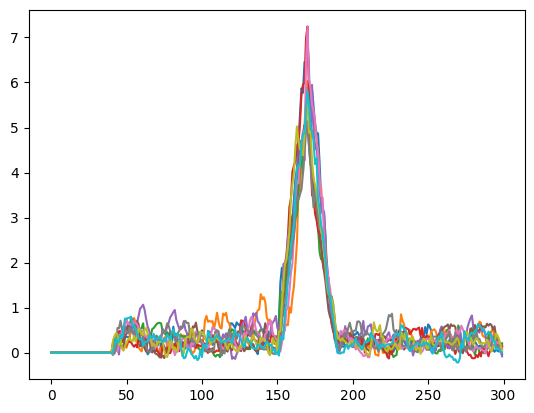

In [24]:
plt.plot(S.T)
plt.show()

### M-statistic

In [25]:
# mmd
def train_params_mmd(b_list, thrs_add=0):
    for b in b_list:
        np.random.seed(1)

        runs = 10
        n = 300
        tau = 150
        dim=3
        sigma = np.array([0.1, 0.2, 0.3])
        mean = np.zeros(dim)
        cov = np.eye(dim)

        S_mmd_0 = np.empty((runs-1, tau))

        #threshold
        for item in range(runs-1):
            X = randmn(mean, cov, size=tau) * sigma[None, :]
            S_mmd, _ = compute_test_stat_mmd(X,window_size=20, sigma=b)
            S_mmd_0[item] = S_mmd

        threshold = np.max(S_mmd_0) + thrs_add
        print(threshold)

        # detect
        S_mmd_list = np.empty((runs, n))
        for item in range(runs):
            X = randmn(mean, cov, size=n) * sigma[None, :]
            X[tau:] += 3*sigma[None, :]
            
            S_mmd, _ = compute_test_stat_mmd(X,window_size=20, sigma=b)
            S_mmd_list[item] = S_mmd


        fa_mmd, DD_mmd, std_DD_mmd, nd = compute_delays_false_alarms(runs, S_mmd_list, threshold, tau)
                
        print('M-statistic.', 'b= ', b, 'Threshold: ', threshold, 'False alarms:', fa_mmd, 'DD: ', DD_mmd, '±', std_DD_mmd, 'nd: ', nd)
    return S_mmd_list

In [28]:
S = train_params_mmd(b_list=[1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5], thrs_add=1)

15.307726546509835
141 1
60 4
M-statistic. b=  1 Threshold:  15.307726546509835 False alarms: 2 DD:  5.9 ± 1.7 nd:  0
9.603042836792923
59 4
50 6
M-statistic. b=  1.5 Threshold:  9.603042836792923 False alarms: 2 DD:  5.2 ± 1.4 nd:  0
6.228984269459783
59 4
51 6
M-statistic. b=  2 Threshold:  6.228984269459783 False alarms: 2 DD:  5.0 ± 1.4 nd:  0
4.448021738683746
59 4
M-statistic. b=  2.5 Threshold:  4.448021738683746 False alarms: 1 DD:  5.6 ± 1.7 nd:  0
3.4340687430145307
60 4
M-statistic. b=  3 Threshold:  3.4340687430145307 False alarms: 1 DD:  5.7 ± 1.6 nd:  0
2.8061866457577933
61 4
M-statistic. b=  3.5 Threshold:  2.8061866457577933 False alarms: 1 DD:  5.7 ± 1.6 nd:  0
2.391860519912583
M-statistic. b=  4 Threshold:  2.391860519912583 False alarms: 0 DD:  6.1 ± 1.8 nd:  0
2.104655830829787
M-statistic. b=  4.5 Threshold:  2.104655830829787 False alarms: 0 DD:  6.3 ± 1.7 nd:  0
1.8976345274999842
M-statistic. b=  5 Threshold:  1.8976345274999842 False alarms: 0 DD:  6.6 ± 1.9 

In [30]:
S = train_params_mmd(b_list=[4], thrs_add=1)

2.391860519912583
M-statistic. b=  4 Threshold:  2.391860519912583 False alarms: 0 DD:  6.1 ± 1.8 nd:  0


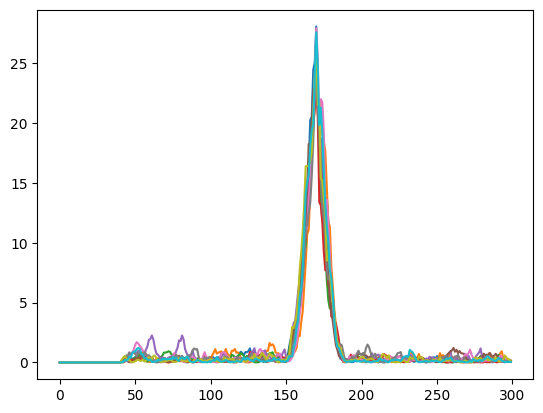

In [31]:
plt.plot(S.T)
plt.show()

## Multivariate variance shift

### FALCON

0.0


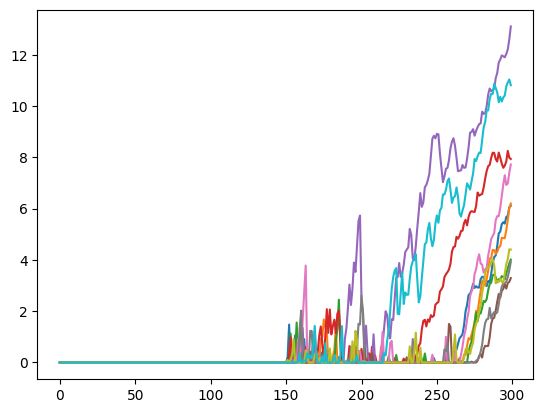

Polynomials. False alarms: 0
polynomial basis 2.5 ± 1.4 nd: 0
0.0


In [32]:
np.random.seed(1)

dim = 3
runs = 10
n = 300
tau = 150

sigma1 = np.array([0.1, 0.2, 0.3])
sigma2 = np.array([0.3, 0.6, 0.9])

mean = np.zeros(dim)
cov = np.eye(dim)

#threshold
S_ftal_0 = np.empty((runs-1, tau))
for item in range(runs-1):
    X = randmn(mean, cov, size=tau) * sigma[None, :]
    S_ftal, _ = compute_test_stat_ftal(X, p=1, beta=0.0001, design='multivariate')
    S_ftal_0[item] = S_ftal

threshold = np.max(S_ftal_0)


# detection
S_ftal_list = np.empty((runs, n))
for item in range(runs):
    X = randmn(mean, cov, size=n)
    X[:tau] *= sigma1[None, :] 
    X[tau:] *= sigma2[None, :] 
    
    S_ftal, _ = compute_test_stat_ftal(X, p=1, beta=1e-4, design='multivariate')
    S_ftal_list[item] = S_ftal



plt.plot(S_ftal_list.T)
plt.show()

fa_ftal, DD_ftal, std_DD_ftal, nd_ftal = compute_delays_false_alarms(runs, S_ftal_list, threshold, tau)
        
print('FALCON. False alarms:', fa_ftal)
print('DD:', DD_ftal, '±', std_DD_ftal, 'nd:', nd_ftal)
print('threshold: ', threshold)



### KLIEP, M-statistic

In [41]:
# kliep, m-stat, cusum

np.random.seed(1)

runs = 10
n = 300
tau = 150
sigma1 = np.array([0.1, 0.2, 0.3])
sigma2 = np.array([0.3, 0.6, 0.9])
mean = np.zeros(dim)
cov = np.eye(dim)

S_kliep_list = np.empty((runs, n))
S_mmd_list = np.empty((runs, n))


#threshold
S_kliep_0 = np.empty((runs-1, tau))
S_mmd_0 = np.empty((runs-1, tau))
for item in range(runs-1):
    X = randmn(mean, cov, size=tau) * sigma[None, :]
    S_kliep, _ = compute_test_stat_kliep(X,window_size=20, sigma=2)
    S_kliep_0[item] = S_kliep
    S_mmd, _ = compute_test_stat_mmd(X,window_size=20, sigma=4)
    S_mmd_0[item] = S_mmd

threshold_kliep = np.max(S_kliep_0) + 0.5
threshold_mmd = np.max(S_mmd_0) +1


# detection
for item in range(runs):
    X = randmn(mean, cov, size=n)
    X[:tau] *= sigma1[None, :] 
    X[tau:] *= sigma2[None, :] 

    S_kliep, _ = compute_test_stat_kliep(X, window_size=20, sigma=2)
    S_kliep_list[item] = S_kliep

    S_mmd, _ = compute_test_stat_mmd(X, window_size=20, sigma=4)
    S_mmd_list[item] = S_mmd


fa_kliep, DD_kliep, std_DD_kliep, nd_kliep = compute_delays_false_alarms(runs, S_kliep_list, threshold_kliep, tau)
        
print('threshold: ', threshold_kliep)
print('kliep. False alarms:', fa_kliep)
print('kliep', DD_kliep, '±', std_DD_kliep, 'nd:', nd_kliep)


fa_mmd, DD_mmd, std_DD_mmd, nd_mmd = compute_delays_false_alarms(runs, S_mmd_list, threshold_mmd, tau)
print('threshold: ', threshold_mmd)
print('mmd. False alarms:', fa_mmd, 'DD: ', DD_mmd, '±', std_DD_mmd, 'nd:', nd_mmd)




threshold:  1.3863627309905455
kliep. False alarms: 0
kliep 31.0 ± 14.4 nd: 0
threshold:  2.391860519912583
mmd. False alarms: 0 DD:  26.3 ± 11.7 nd: 0
